# Breakout - Policy Gradient Method
## Policy Gradients Vanilla type
* Borrowed heavily from structure of: [Vanilla Policy Gradient](https://github.com/awjuliani/DeepRL-Agents/blob/master/Vanilla-Policy.ipynb)
* In order to determine positive and negative rewards we must associate it with some direction of the pole

In [1]:
import tensorflow as tf
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation, convolutional, pooling, Flatten, Dropout, Input, BatchNormalization
from keras.optimizers import Adam
from keras import backend as Bk
from scipy.misc import imread, imshow
import math
import numpy as np
import matplotlib.pyplot as plt
import gym
%matplotlib inline

Using TensorFlow backend.


In [2]:
env = gym.make('Breakout-v0')
print(env.observation_space)  # 210v x 160w x 3color Box (sparse tensor!!!)
print(env.action_space)       # 6x1 Discrete
s = env.reset()
print(s.shape)
gamma = 0.99
try: 
    xrange(1)
except:
    xrange = range

[2017-05-27 13:56:20,514] Making new env: Breakout-v0


Box(210, 160, 3)
Discrete(6)
(210, 160, 3)


In [40]:
class rl_agent():
    def __init__(self,  
                 environment, 
                 state_space_size, 
                 action_space_size,               
                 hidden_units = 1024,
                 learning_rate = .003,             # Lambda or other for gradient descent
                 epsilon = 1e-8,                  # Error - error for types of gradient descent or random choice
                 random_choice_threshold = -1.75,
                 optimizer = Adam,
                 dropout_rate = 0.5,
                 load_file_weights = None,
                 verbose = 0,
                 frames = 3
                ):
        self.environment = environment
        self.hidden_units = hidden_units # hidden neurons
        self.state_space_size = state_space_size
        self.action_space_size = action_space_size
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.optimizer = optimizer
        self.dropout_rate = dropout_rate
        self.verbose = verbose
        self.frames = frames
        self.input_dim = 6400
        self.prev_processed_state = None
        self.past_differences = []
        self.render = False
        self.random_choice_threshold = random_choice_threshold
        
    def define_model(self):
        # Keras vars
        self.model = Sequential()
        # Default is channels last
        self.model.add(convolutional.Conv2D(filters=128, kernel_size = (2,2), strides=(2,2), padding='same', input_shape = (80,80, 1)))
        self.model.add(BatchNormalization())
        self.model.add(Activation('relu'))
        self.model.add(convolutional.Conv2D(filters=128, kernel_size = (2,2), strides=(2,2), padding='valid', input_shape = (80,80, 1)))
        self.model.add(BatchNormalization())
        self.model.add(Activation('relu'))
        self.model.add(convolutional.Conv2D(filters=128, kernel_size = (2,2), strides=(1,1), padding='valid', input_shape = (80,80, 1)))
        self.model.add(BatchNormalization())
        self.model.add(Activation('relu'))
        print(self.model.layers[-1].input_shape)
        print(self.model.layers[-1].output_shape)
        self.model.add(Flatten())
        self.model.add(Dense(self.hidden_units))   # Karpathy suggested N=200 in the hidden layer
        self.model.add(Dropout(self.dropout_rate))      # But since we are doing dropout to avoid overfitting... increase
        self.model.add(BatchNormalization())
        self.model.add(Activation('relu'))
        self.model.add(Dense(self.hidden_units//2))   # Karpathy suggested N=200 in the hidden layer
        self.model.add(Dropout(self.dropout_rate))      # But since we are doing dropout to avoid overfitting... increase
        self.model.add(BatchNormalization())
        self.model.add(Activation('relu'))
        print(self.model.layers[-1].input_shape)
        print(self.model.layers[-1].output_shape)
        self.model.add(Dense(6, activation='softmax'))  # Actions are a 6x1 vector
        optimizer = self.optimizer(lr=self.learning_rate, decay=1e-6)
        self.model.compile(
            optimizer = optimizer,
            loss='mse',
            metrics=['accuracy']
        )
        
        try:
             self.model.load_weights('saved_weights15.h5')
        except:
            print("Training model without old weights")
            
        # State space size will be a 210x160x1 dim
        self.state = Input(shape=[80,80,1])
        
        if self.verbose >= 1:
            print(self.model.summary())
        
    def training(self, max_games = 100000):
        mean_rewards_list = []
        self.state = self.environment.reset()
        chosen_vectors, rewards, rewards_history, episode_rewards_hx = [], [], [], []
        running_reward = 0
        reward_for_episode = 0
        i = 0
        while True:
            history_element, done = self.choose_action()
            chosen_vectors.append(history_element[4]) # store the one-hot action choices
            reward_for_episode += float(history_element[3]) # store the total episode's value
            rewards.append(history_element[3]) # store the rewards realted to each action (one-hots)
            rewards_history.append(history_element[3]) # just for visualization
            # when the episode is over, do the training
            if done:
                i += 1
                all_episode_features = np.vstack(agent.past_differences) # the features we predict on and fit on
                all_episode_chosen_vectors = np.vstack(chosen_vectors) # the vectors of the action choice one-hots
                all_episode_rewards = np.vstack(rewards) # the rewards 
                discounted_episode_rewards = apply_gamma(all_episode_rewards) # discount the history 
                # Standard normal feature scaling, but adding epsilon to std deviation to avoid /0 errors
                std_dev = np.std(discounted_episode_rewards)+self.epsilon
                discounted_episode_rewards -= np.mean(discounted_episode_rewards)
                discounted_episode_rewards /= std_dev
                all_episode_chosen_vectors *= discounted_episode_rewards
                # train model every episode! That's a lot of work and really only pays off after we eventually
                # learn something about the relation between the actions and the states that result
                # The targets are the modified one-hot vectors 
                self.model.fit(all_episode_features.reshape([-1,80,80,1]), 
                               all_episode_chosen_vectors, epochs=1, verbose=0)
                self.prev_processed_state = None
                episode_rewards_hx.append(reward_for_episode)
                reward_for_episode = 0
                self.state = self.environment.reset()
                self.past_differences = []
                chosen_vectors = []
                rewards = []
                if i % 100 == 0 and i != 0:
                    rewardhx = np.vstack(rewards_history)
                    rewards_history = []
                    mean_rewards = np.mean(rewardhx)
                    self.saveweights()
                    self.savemodel()
                    print(np.mean(episode_rewards_hx[-20:]))
                    print("MEAN REWARDS:" + str(mean_rewards))
                    
    def savemodel(self):
        with open('saved_model15.json', 'w') as modelfile:
            modelfile.write(self.model.to_json())
            
    def saveweights(self):
        self.model.save_weights('saved_weights15.h5', overwrite=True)
        
    def choose_action(self):
        #Probabilistically pick an action given our network outputs.
        self.state = self.preprocess(self.state)
        s = self.state
        if self.prev_processed_state is None:
            # prev_processed_state does not exist yet, so we take the difference from 0s
            self.prev_processed_state = np.zeros((1, 80, 80, 1), dtype='float32')
        difference_processed = (s - self.prev_processed_state) # fit and predict off the difference values between steps
        self.prev_processed_state = s # update for next iteration calculation
        self.past_differences.append(difference_processed) # Keep track of the differences for fitting in training
        # Create a flattened np array of the result of the prediction a 6x1 vector from softmax
        self.action_probabilities = self.model.predict(difference_processed.reshape([-1,80,80,1]), batch_size=1).flatten()
        # Introduce exploration based on a gaussian distribution, we use a very low probability for exploration
        # Such as testing if e < -.5,
        e = np.random.normal() # range from [~-3.5, ~3.5] where a distribution is according the CDF of the gaussian
        if (e < self.random_choice_threshold):
            action = np.random.choice(self.environment.action_space.n, 1)[0]
        else:
            # Choose according to the policy gradient (the prediction's probabilities become the distribution)
            action = np.random.choice(self.environment.action_space.n, 1,
                                      p=self.action_probabilities/np.sum(self.action_probabilities))[0]
        # Make the step and return the results to the train function (caller)
        self.state, reward, done, info = self.environment.step(action)
        if self.render: self.environment.render()
        chosen_vector = np.zeros([self.environment.action_space.n])
        chosen_vector[action] = 1
        return [s,action, self.state, reward, chosen_vector], done
    
    def preprocess(self, state):
        # take a 210x160x3 image and convert to 210x160x1 as 210*160 length vector flattened F = float32 in dim
        # From https://docs.scipy.org/doc/scipy/reference/generated/scipy.misc.imread.html
        #r, g, b = state[:, :, 0], state[:, :, 1], state[:, :, 2]
        #F = r * 299.0/1000 + g * 587.0/1000 + b * 114.0/1000
        # Now using Karpathy 0/1 conversion of a majority of the surface area of the screen down to 80x80
        F = state
        F = F[35:195] # crop vertical rows to 160
        F = F[::2,::2,0] # downsample by factor of 2 to 80x80 just keeps the first index of the 3rd dim
        F[F != 0] = 255 # everything else (paddles, ball) just set to 1
        F[F != 255] = 0
        return F.reshape([1,80,80,1])

In [41]:
def apply_gamma(r):
    discounted_r = np.zeros_like(r)
    running_add = 0
    r = r.flatten()
    for t in reversed(xrange(0, r.size)):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

In [42]:
agent = rl_agent(
    environment=env,
    state_space_size=(6400,1),
    action_space_size=6,
    hidden_units=512,
    epsilon=1e-8, 
    optimizer=Adam,
    verbose=1)
agent.define_model()

(None, 19, 19, 128)
(None, 19, 19, 128)
(None, 256)
(None, 256)
Training model without old weights
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 40, 40, 128)       640       
_________________________________________________________________
batch_normalization_43 (Batc (None, 40, 40, 128)       512       
_________________________________________________________________
activation_45 (Activation)   (None, 40, 40, 128)       0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 20, 20, 128)       65664     
_________________________________________________________________
batch_normalization_44 (Batc (None, 20, 20, 128)       512       
_________________________________________________________________
activation_46 (Activation)   (None, 20, 20, 128)       0         
___________________________________________

In [43]:
agent.training()

1.5
MEAN REWARDS:0.00659567705022


KeyboardInterrupt: 

TypeError: Invalid dimensions for image data

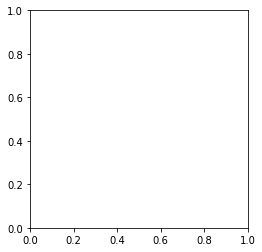

In [32]:
plt.imshow(agent.preprocess(agent.state))

In [23]:
plt.hist(agent.reward_tensor)

[200  72  72]
